In [1]:
%pip install pandas==1.5.1
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 4.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.0 MB/s 


In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import image as mpimg
import re
from PIL import Image
import pandas as pd
from torchmetrics import TweedieDevianceScore
sns.set_style('whitegrid')

# Random split function

In [3]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting up data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH='/content/drive/MyDrive/MLproject/'

In [7]:
with open(PATH+"listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open(PATH+"test_listings_image.pkl", "rb") as fh:
    data_test = pickle.load(fh)

In [8]:
import glob
import os


#os.path.basename(csv_files[0])
img_files = glob.glob(PATH+'Images'+ "/*")

In [9]:
list_ids=[img_file.replace(PATH+'Images/',"") for img_file in img_files]
print('There are ',len(list_ids),' differents property reference ids in the image dataset')

There are  126  differents property reference ids in the image dataset


In [10]:
data_ids=data['Property Reference Id'].to_list()
data_test_ids=data_test['Property Reference Id'].to_list()
print('There are ',len(data_ids),' differents property reference ids in the general dataset')
print('There are ',len(data_test_ids),' differents property reference ids in the test dataset')

There are  20000  differents property reference ids in the general dataset
There are  10000  differents property reference ids in the test dataset


In [11]:
print('There are ',len(set(list_ids)-set(data_ids)),' property reference ids in the image dataset but not in the general dataset')
print('There are ',len(set(data_ids)-set(list_ids)),' property reference ids in the general dataset but not in the image dataset')
print('There are ',len(set(list_ids)-set(data_test_ids)),' property reference ids in the image dataset but not in the test dataset')
print('There are ',len(set(data_test_ids)-set(list_ids)),' property reference ids in the test dataset but not in the image dataset')

There are  49  property reference ids in the image dataset but not in the general dataset
There are  14622  property reference ids in the general dataset but not in the image dataset
There are  86  property reference ids in the image dataset but not in the test dataset
There are  8385  property reference ids in the test dataset but not in the image dataset


In [12]:
len(set(data_ids))

14699

In [13]:
#Getting the folder corresponding to ids in both the img dataset and the general data set
list_folder_workable=[x for x in img_files if x.replace(PATH+'Images/',"") in data_ids]
list_id_workable=[x.replace(PATH+'Images/',"") for x in img_files if x.replace(PATH+'Images/',"") in data_ids]
list_id_workable_test=[x.replace(PATH+'Images/',"") for x in img_files if x.replace(PATH+'Images/',"") in data_test_ids]
print('train:',len(list_id_workable),'test:',len(list_id_workable_test))

train: 77 test: 40


In [14]:
#Keeping only data for those
data_sub=data[data['Property Reference Id'].isin(list_id_workable)].drop_duplicates(subset='Property Reference Id')
data_sub

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,...,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
600,False,APPT,"July 11, 2018","October 1, 2018",7.0,3.0,LU,Emmenbrücke,6020,False,...,7,220.0,1220.0,22.0,1000.0,9201.61.6571,56.0,Apartment,NaN,NaN
1130,NaN,APPT,"June 29, 2021","October 1, 2021",5.0,1.0,SZ,Brunnen,6440,NaN,...,10,250.0,1968.0,21.0,1718.0,5011.24.4593,94.0,Apartment,2013.0,2013.0
1261,False,APPT,"August 21, 2018","October 1, 2018",0.0,2.0,SZ,Brunnen,6440,False,...,5,220.0,2022.0,22.0,1802.0,5011.38.4593,93.0,Apartment,NaN,NaN
1364,NaN,APPT,"January 8, 2021",NaN,1.0,2.0,LU,Luzern,6005,NaN,...,9,230.0,1600.0,21.0,1370.0,9135.61.0065,76.0,Apartment,1956.0,2014.0
1604,NaN,APPT,"August 6, 2020",NaN,0.0,3.0,LU,Ebikon,6030,NaN,...,7,200.0,1850.0,19.0,1650.0,2905.61.6571,95.0,Apartment,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18021,NaN,APPT,"August 2, 2021",NaN,10.0,0.0,SZ,Brunnen,6440,NaN,...,11,240.0,1980.0,21.0,1740.0,5011.24.7822,93.0,Apartment,2013.0,2013.0
18698,NaN,APPT,"January 20, 2020","April 1, 2020",4.0,2.0,SZ,Brunnen,6440,NaN,...,7,120.0,1370.0,25.0,1250.0,4731.61.5664,55.0,Apartment,2014.0,2014.0
19021,False,APPT,"December 18, 2017","April 1, 2018",0.0,3.0,LU,Luzern,6014,False,...,5,250.0,2135.0,18.0,1885.0,0214.26.6915,118.0,Apartment,NaN,NaN
19136,False,APPT,"May 7, 2018","July 1, 2018",0.0,2.0,SZ,Brunnen,6440,False,...,7,300.0,2186.0,18.0,1886.0,4731.61.3230,123.0,Apartment,NaN,NaN


In [15]:
def image_plot(path):
  files=glob.glob(path+ "/*")
  n_files=len(files)
  print('There are ',n_files,' images for this id')
  #f, axarr = plt.subplots(n_files,1) 
  for i,file in enumerate(files):
    #image = mpimg.imread(file) also works btw
    image=Image.open(file)
    print(np.array(image).shape)
    plt.imshow(image)
    plt.show()
    #plt.imshow(image.transpose(Image.ROTATE_90))
    #plt.show()
    #plt.imshow(image.transpose(Image.FLIP_LEFT_RIGHT)) 
    #plt.show()
    #axarr[i].imshow(image)
  #plt.show()

There are  11  images for this id
(413, 600, 3)


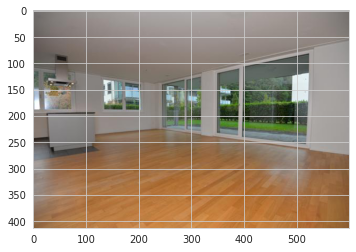

(406, 600, 3)


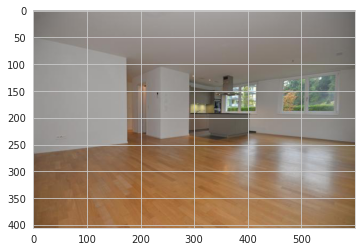

(401, 600, 3)


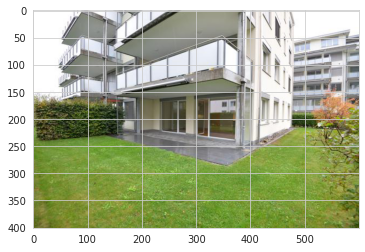

(600, 401, 3)


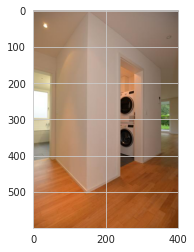

(401, 600, 3)


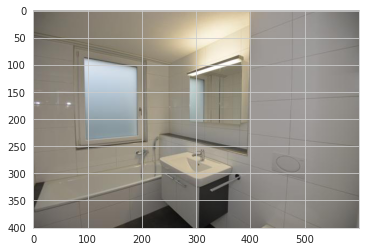

(477, 600, 3)


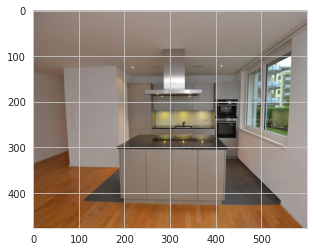

(401, 600, 3)


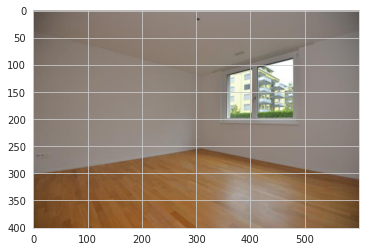

(600, 401, 3)


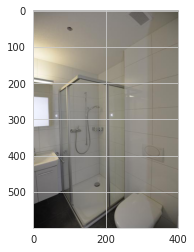

(401, 600, 3)


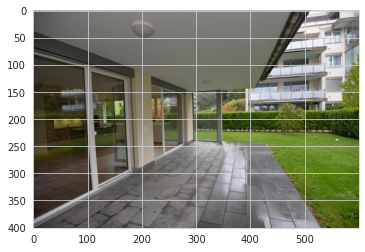

(401, 600, 3)


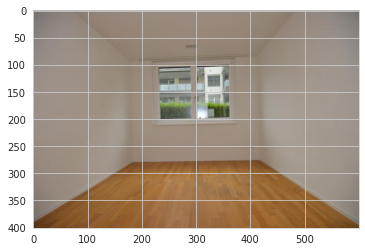

(600, 385, 3)


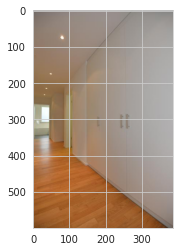

In [16]:
image_plot(list_folder_workable[3])

# Creating a dataset class with the images

In [68]:
#Creating a data set with the demand and the file name (only one image by id for now)
df=data_sub.set_index('Property Reference Id')['Demand'].to_frame()
list_list_image=[glob.glob(list_folder_workable[i]+ "/*") for i in range(len(list_folder_workable))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})
#display(df_filename.head())

data_file=df_filename.join(df,on='Property Reference Id')
data_file.to_csv(PATH+'data.csv')

data_file

,Property Reference Id,File Name,Demand
0,8396.61.5664,/content/drive/MyDrive/MLproject/Images/8396.6...,1.0
1,8396.61.5664,/content/drive/MyDrive/MLproject/Images/8396.6...,1.0
2,8396.61.5664,/content/drive/MyDrive/MLproject/Images/8396.6...,1.0
3,8396.61.5664,/content/drive/MyDrive/MLproject/Images/8396.6...,1.0
4,8396.61.5664,/content/drive/MyDrive/MLproject/Images/8396.6...,1.0
...,...,...,...
600,4253.61.2623,/content/drive/MyDrive/MLproject/Images/4253.6...,1.0
601,0214.50.8006,/content/drive/MyDrive/MLproject/Images/0214.5...,3.0
602,0214.50.8006,/content/drive/MyDrive/MLproject/Images/0214.5...,3.0
603,0214.50.8006,/content/drive/MyDrive/MLproject/Images/0214.5...,3.0


In [69]:
class MyCustomDataset(Dataset):
  def __init__(self,csv_path,img_dir,transform=None):
    df=pd.read_csv(csv_path)
    self.img_dir=img_dir
    self.img_id=df['File Name'].to_frame()
    self.y=df['Demand'].to_frame()
    self.transform=transform

  def __getitem__(self,index):
    img=Image.open(os.path.join(self.img_dir,self.img_id.iloc[index]['File Name']))
    if self.transform:
      img=self.transform(img)
    #Have uniform orientation (should be done in transform?)
    #if np.array(img).shape[0]<np.array(img).shape[1]:
    #  img=img.transpose(Image.ROTATE_90)
    label=torch.tensor(self.y.iloc[index]['Demand'],device=device,dtype=torch.float32)
    return img,label

  def __len__(self):
    return self.y.shape[0]





In [70]:
#We work with square image for now
img_size=(150,150)
resize_transformer=transforms.Resize(img_size)
transformer=transforms.Compose([resize_transformer,
                                transforms.ToTensor()])

Demand: tensor(1., device='cuda:0')
tensor([[[0.9255, 0.9255, 0.9216,  ..., 0.8941, 0.8941, 0.8941],
         [0.9255, 0.9255, 0.9216,  ..., 0.8941, 0.8941, 0.8941],
         [0.9255, 0.9255, 0.9216,  ..., 0.8941, 0.8941, 0.8941],
         ...,
         [0.7137, 0.7216, 0.7176,  ..., 0.6784, 0.7333, 0.7647],
         [0.7216, 0.7216, 0.7176,  ..., 0.8000, 0.7686, 0.7490],
         [0.7216, 0.7098, 0.7176,  ..., 0.8118, 0.8275, 0.8196]],

        [[0.9098, 0.9098, 0.9059,  ..., 0.8824, 0.8824, 0.8824],
         [0.9098, 0.9098, 0.9059,  ..., 0.8824, 0.8824, 0.8824],
         [0.9098, 0.9098, 0.9059,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.6667, 0.6745, 0.6706,  ..., 0.6588, 0.7176, 0.7490],
         [0.6745, 0.6745, 0.6706,  ..., 0.7961, 0.7529, 0.7333],
         [0.6745, 0.6627, 0.6706,  ..., 0.8235, 0.8157, 0.8039]],

        [[0.8980, 0.8980, 0.8941,  ..., 0.8627, 0.8627, 0.8627],
         [0.8980, 0.8980, 0.8941,  ..., 0.8627, 0.8627, 0.8627],
         [0.8980, 0.89

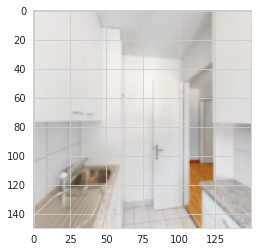

In [71]:
dataset=MyCustomDataset(PATH+'data.csv',PATH+'Images',transform=transformer)
sample=dataset[0]
print('Demand:', sample[1])
print(sample[0])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

In [72]:
batch_size=10
train_set,test_set=random_split(dataset, lengths=[0.8,0.2])
train_loader=DataLoader(dataset=train_set,batch_size=batch_size,drop_last=True,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,drop_last=True,shuffle=True)

print(batch_size)
print(len(train_loader))
print(len(test_set))
print(len(test_loader))
print(len(train_loader.dataset))

10
48
121
12
484


# Defining the model

In [73]:
#CNN Network
class ConvNet(nn.Module):
  def __init__(self,img_size=img_size,dim_output=1):
    super(ConvNet,self).__init__()

    #Output size after convolution filter:
    #((width-kernel_size+2Padding)/stride)+1
    
    #Default Input shape (batch_size,num_channel,img_size[0],img_size[1])=(4,3,150,150)
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
    #Shape=(4,12,150,150)
    self.bn1=nn.BatchNorm2d(num_features=12)
    #Shape=(4,12,150,150)
    self.relu1=nn.ReLU()
    #Shape=(4,12,150,150)

    self.pool=nn.MaxPool2d(kernel_size=2)
    #Reduce the image size by a factor 2
    #Shape=(4,12,75,75)

    self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
    #Shape=(4,20,75,75)
    self.bn2=nn.BatchNorm2d(num_features=20)
    #Shape=(4,20,75,75)
    self.relu2=nn.ReLU()
    #Shape=(4,20,75,75)

    self.fc=nn.Linear(in_features=20*75*75,out_features=dim_output)

  #Feed forward function:

  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.pool(output)

    output=self.conv2(output)
    output=self.bn2(output)
    output=self.relu2(output)

    #Above output will be in matrix form with shape (4,20,75,75)

    output=output.view(-1,20*75*75)

    output=self.fc(output)

    return output



In [74]:
model=ConvNet().to(device)

In [129]:
#Optimizer and loss function
optimizer=Adam(model.parameters(),lr=0.00001,weight_decay=0.0001)
loss_function=torch.nn.MSELoss()
num_epochs=20

# Model Training

In [130]:
def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels

    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()


In [131]:
for epoch in range(num_epochs):

  model.train()

  for batch, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images=Variable(images.to(device))
      labels=Variable(labels.to(device))
  
    output=model(images)
    loss=loss_function(output,labels.view_as(output))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('epoch',epoch,'loss',loss.item())

  
  # # Test the quality on the test set
  # model.eval()
  # accuracies_test = []
  # for batch_x, batch_y in test_loader:
  #     batch_x, batch_y = batch_x.to(device), batch_y.to(device)

  #     # Evaluate the network (forward pass)
  #     prediction = model(batch_x)
  #     accuracies_test.append(accuracy(prediction, batch_y))

  # print(
  #     "Epoch {} | Test accuracy: {:.5f}".format(
  #         epoch, sum(accuracies_test).item() / len(accuracies_test)
  #     )
  # )
    

epoch 0 loss 0.3065832853317261
epoch 1 loss 3.7381927967071533
epoch 2 loss 1.7906286716461182
epoch 3 loss 0.7637427449226379
epoch 4 loss 0.32856667041778564
epoch 5 loss 1.1033743619918823
epoch 6 loss 1.9075326919555664
epoch 7 loss 3.406013250350952
epoch 8 loss 4.602095603942871
epoch 9 loss 4.388989448547363
epoch 10 loss 0.7482220530509949
epoch 11 loss 2.406853437423706
epoch 12 loss 1.0062769651412964
epoch 13 loss 1.0010474920272827
epoch 14 loss 5.049790382385254
epoch 15 loss 5.7687177658081055
epoch 16 loss 3.0189731121063232
epoch 17 loss 5.212226390838623
epoch 18 loss 2.0817763805389404
epoch 19 loss 0.8871473670005798


In [132]:
def test(data_loader, model, loss_function):
  list_predictions = []
  list_labels = []

  size = len(data_loader.dataset)
  num_batches = len(data_loader)
  model.eval()

  test_loss, correct = 0, 0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      pred = model(images)

      list_predictions.append(pred.cpu().numpy())
      list_labels.append(labels.cpu().numpy())

      test_loss += loss_function(pred, labels).item()
      correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
      test_loss /= num_batches
      correct /= size
      print(f"Test Error: \n Accuracy: {(100*correct) :>0.1f}%, Avg loss: {test_loss:>8f}\n")

  return list_predictions, list_labels

predictions, labels = test(test_loader, model, loss_function)

# print(predictions)
# print(labels)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Accuracy: 2.5%, Avg loss: 1.754866

Test Error: 
 Accuracy: 2.5%, Avg loss: 2.253527

Test Error: 
 Accuracy: 3.3%, Avg loss: 2.678424

Test Error: 
 Accuracy: 2.5%, Avg loss: 1.182106

Test Error: 
 Accuracy: 3.3%, Avg loss: 2.471800

Test Error: 
 Accuracy: 1.7%, Avg loss: 1.007336

Test Error: 
 Accuracy: 2.5%, Avg loss: 1.430060

Test Error: 
 Accuracy: 1.7%, Avg loss: 1.584400

Test Error: 
 Accuracy: 2.5%, Avg loss: 0.921042

Test Error: 
 Accuracy: 3.3%, Avg loss: 0.956372

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.542631

Test Error: 
 Accuracy: 4.1%, Avg loss: 0.758145



In [133]:
pred = []
lab = []

for i in range(len(predictions)):
  for elt in predictions[i]:
    pred.append(elt[0])
pred = [max(10**(-9),k) for k in pred]

for i in range(len(labels)):
  for elt in labels[i]:
    lab.append(elt)
lab = [max(10**(-9),k) for k in lab]


print(pred)
print(len(pred))

print(lab)
print(len(lab))




[6.446936, 3.2304342, 6.5816064, 4.091492, 4.071966, 6.9129558, 0.5059756, 3.9899728, 1.7586869, 3.910335, 5.7875056, 2.1840765, 9.730763, 5.1346464, 1.8670194, 2.4644294, 1e-09, 11.666346, 1e-09, 2.6036415, 0.6330243, 6.6860557, 3.0399973, 7.777445, 2.5620704, 6.0042987, 3.295809, 3.9043143, 2.2557805, 1e-09, 2.2212143, 4.7096486, 0.82641107, 1.954522, 3.1767209, 5.6907687, 3.5834908, 6.021703, 2.0106335, 2.7345574, 2.9006019, 0.16514209, 5.9456, 0.82641107, 1.7293966, 2.820956, 6.007736, 1.0796454, 0.93642825, 3.7130191, 2.4700265, 1.7880772, 4.236098, 1.6521703, 5.7034054, 7.0564404, 4.471941, 4.0123086, 0.93642825, 1.2757097, 2.3071764, 5.195914, 1.4939548, 9.167157, 2.4712753, 0.9774253, 5.001947, 0.23183331, 4.6412044, 4.372438, 6.391333, 1.5898898, 5.455462, 5.714359, 2.659989, 0.5161192, 2.808561, 5.583549, 1e-09, 2.8153808, 4.666307, 4.4321227, 4.073009, 1.0218624, 5.382496, 1.3469462, 1.9614282, 2.9928749, 4.405257, 1e-09, 2.509335, 6.0894136, 4.9022365, 3.0920367, 2.0648718,

In [134]:
#Using Mean Poisson deviance
from sklearn.metrics import mean_poisson_deviance

print("Mean Poisson deviance for SVR :", mean_poisson_deviance(pred, lab))

Mean Poisson deviance for SVR : 41.08970939606194


# Ideas to improve : 
- Gather images by ID and puting a average/mode/middle/(?) prediction for each ID 
- Add layers in the NNet
- Find ways to choose optimal parameters : nb of epoch, batch_size, lr and
 weight_decay